# CLASSIFICATION
we need stratification since High_Spend has so low partecipants

In [53]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn import tree
import pydotplus 
from IPython.display import Image 
from collections import Counter

In [2]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [3]:
# Starting dataset
df = pd.read_csv('clustered_dataframe.csv', sep='\t', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TProd           4333 non-null   int64  
 1   DProd           4333 non-null   int64  
 2   MeanProdOrder   4333 non-null   float64
 3   TSale           4333 non-null   float64
 4   MinPSale        4333 non-null   float64
 5   MaxPSale        4333 non-null   float64
 6   MeanSaleOrder   4333 non-null   float64
 7   TRProd          4333 non-null   int64  
 8   MeanPSale       4333 non-null   float64
 9   TOrder          4333 non-null   int64  
 10  SETSaleQta      4333 non-null   float64
 11  SESaleQtaOrder  4333 non-null   float64
 12  MaxOrderMonth   4333 non-null   object 
 13  Label           4333 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 507.8+ KB


In [4]:
df = discretize_data(df,['MaxOrderMonth','Label'])

In [5]:
df.drop(columns=['MaxOrderMonth','Label'], inplace=True, errors='ignore')
df_class = df.copy()
df_class.tail()

,TProd,DProd,MeanProdOrder,TSale,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,SETSaleQta,SESaleQtaOrder,MaxOrderMonth_num,Label_num
CustomerID,,,,,,,,,,,,,,
13436,76,12,76.0,196.89,10.20,25.50,196.89,0,5.830,1,3.418,0.0,1,1
15520,314,18,314.0,343.50,9.48,34.68,343.50,0,1.724,1,2.997,0.0,1,1
13298,96,2,96.0,360.00,90.00,270.00,360.00,0,3.750,1,1.000,0.0,1,1
14569,79,10,79.0,227.39,1.65,122.40,227.39,0,3.920,1,3.418,0.0,1,1
12713,505,37,505.0,794.55,5.04,71.70,794.55,0,2.085,1,4.101,0.0,11,2


## Decision Tree

In [6]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
label = df_class.pop('Label_num')
train_set, test_set, train_label, test_label = train_test_split(df_class, label, stratify =label, test_size=0.30)

In [7]:
#define a decision tree and fit it
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=3, min_samples_leaf=8)
dt = dt.fit(train_set, train_label)

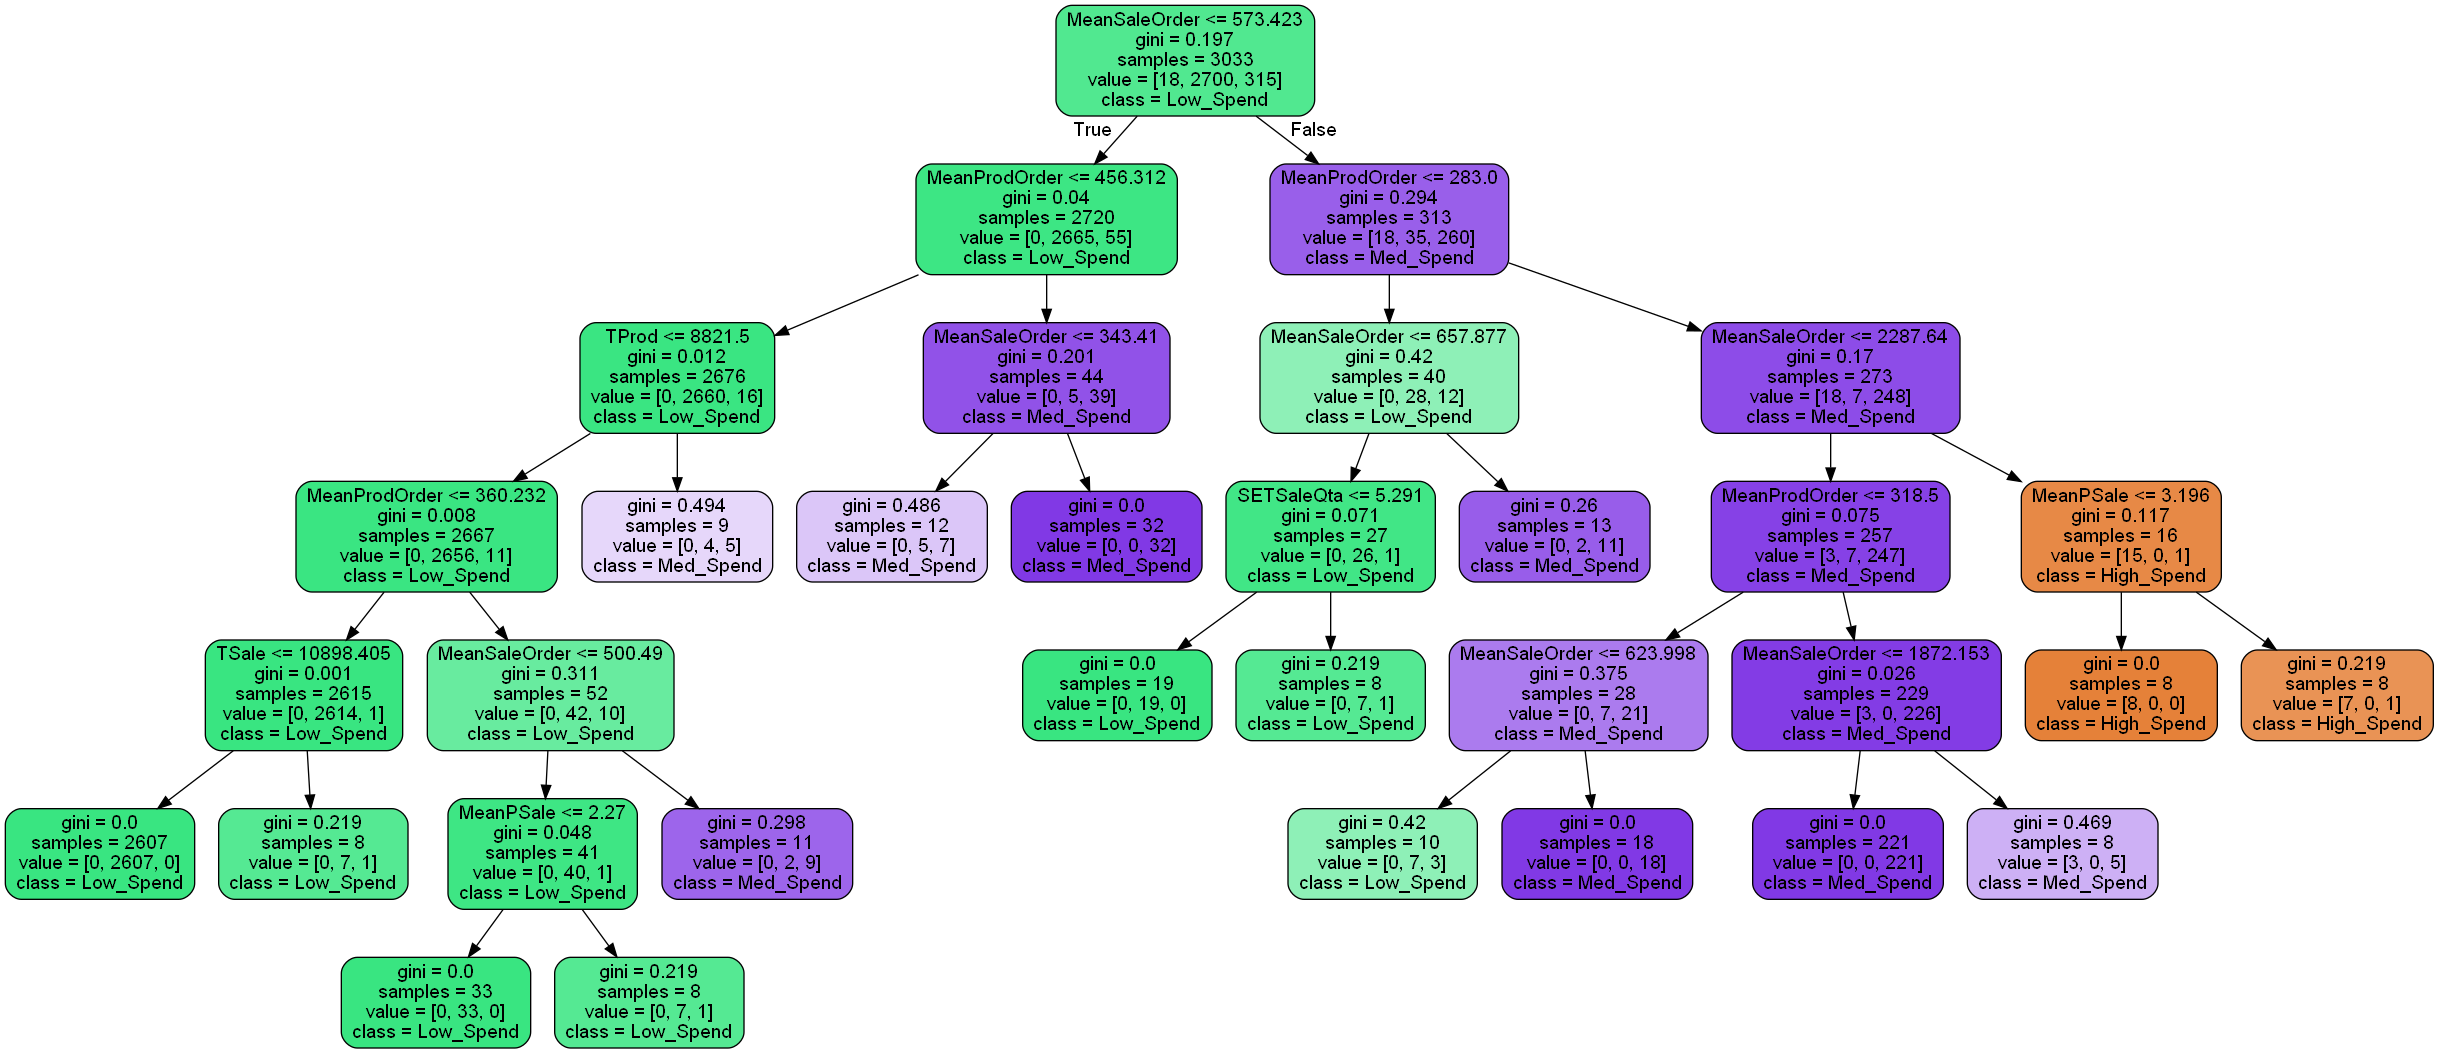

In [8]:
#visualize the actual decision tree obtained  
classes = ['High_Spend','Low_Spend','Med_Spend']
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=classes,  #in transforming to numerical this order is mapped to 0,1,2 because of lexicographical
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [9]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

In [10]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.9924167490933069
Accuracy test set  0.9846153846153847
Precision train set  0.9925169299224667
Recall train set  0.9924167490933069
F1 score train set  0.9924272977161155
Support train set  (array([0.9375    , 0.997772  , 0.95061728]), array([0.83333333, 0.99518519, 0.97777778]), array([0.88235294, 0.99647691, 0.96400626]), array([  18, 2700,  315], dtype=int64))


In [11]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=classes))

In [12]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  High_Spend       0.80      0.50      0.62         8
   Low_Spend       1.00      0.99      0.99      1157
   Med_Spend       0.88      0.99      0.93       135

    accuracy                           0.98      1300
   macro avg       0.89      0.82      0.85      1300
weighted avg       0.99      0.98      0.98      1300



In [13]:
#cross validation
#the score array for test/train scores on each cv split
#the time for fitting/scoring the estimator on the train set for each cv split
from sklearn.model_selection import cross_validate
import statistics 
scores = cross_validate(dt, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.01275030771891276
Score time  0.0006898244222005209
Test score  0.9845037916254533
Train score  0.9919221892515662


In [14]:
#compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[   4,    0,    4],
       [   0, 1143,   14],
       [   1,    1,  133]], dtype=int64)

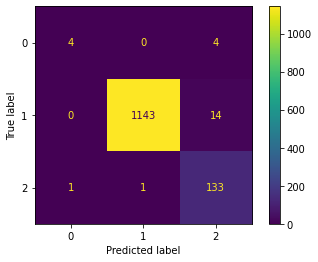

In [15]:
#it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(dt, test_set, test_label)
plt.show() 

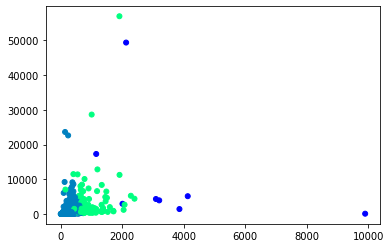

In [16]:
from sklearn.datasets import make_blobs
plt.scatter(test_set.iloc[:, 6].values, test_set.iloc[:, 0].values, c=test_label.values, s=25, cmap='winter');

# Classification with Naive Bayes

In [17]:
#import, define and fit the model
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(train_set, train_label)

#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [18]:
#compute the performance of the model
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.44      0.88      0.58         8
   Low_Spend       0.97      0.95      0.96      1157
   Med_Spend       0.65      0.73      0.69       135

    accuracy                           0.93      1300
   macro avg       0.69      0.85      0.74      1300
weighted avg       0.93      0.93      0.93      1300



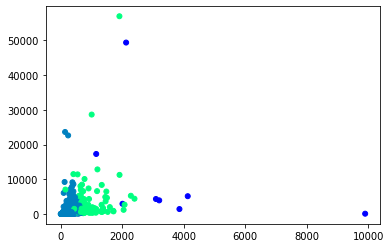

In [19]:
from sklearn.datasets import make_blobs
plt.scatter(test_set.iloc[:, 6].values, test_set.iloc[:, 0].values, c=test_label.values, s=25, cmap='winter');

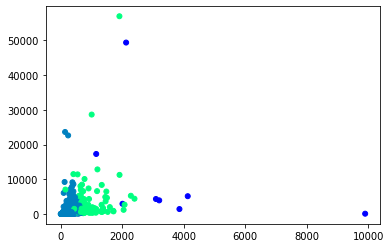

In [20]:
plt.scatter(test_set.iloc[:, 6].values, test_set.iloc[:, 0].values, c=test_label.values, s=25, cmap='winter');

# Classification with KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [22]:
#prediction on the test test
test_pred_knn = knn.predict(test_set)

In [23]:
#compute the performance of the model
report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       1.00      0.25      0.40         8
   Low_Spend       0.98      0.99      0.99      1157
   Med_Spend       0.90      0.82      0.86       135

    accuracy                           0.97      1300
   macro avg       0.96      0.69      0.75      1300
weighted avg       0.97      0.97      0.97      1300



# Classification with Random Forest

In [24]:
#define and fit a random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=3,
                             max_depth=10, 
                             min_samples_split=3,
                             min_samples_leaf=8,
                             bootstrap=True) 
rf = rf.fit(train_set, train_label)

In [25]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

In [26]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       1.00      0.38      0.55         8
   Low_Spend       1.00      1.00      1.00      1157
   Med_Spend       0.94      0.99      0.96       135

    accuracy                           0.99      1300
   macro avg       0.98      0.79      0.84      1300
weighted avg       0.99      0.99      0.99      1300



### Grid search for parameter setting 

In [27]:
#to find the best set of parameter setting, we can run a grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(3, 51),
              "min_samples_leaf": sp_randint(5, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"]}
#define the number of iters
n_iter_search = 50
#define the model
clf = RandomForestClassifier(n_estimators=30)
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=1, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None,
                                                         {0: 0.3, 1: 0.7}],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018379B612E0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018379B616D0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018379B61550>},
                   scoring=make_scorer(accuracy_score

In [28]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': 8, 'min_samples_leaf': 29, 'min_samples_split': 48}
Mean and std of this setting  0.9363699631907177 0.01622471326579082


In [29]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='entropy',
                             max_features=12,
                             max_depth=3, 
                             min_samples_split=3,
                             min_samples_leaf=38,
                             bootstrap=False) 
rf = rf.fit(train_set, train_label)

In [30]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

In [31]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       0.00      0.00      0.00         8
   Low_Spend       0.99      0.99      0.99      1157
   Med_Spend       0.87      0.96      0.91       135

    accuracy                           0.98      1300
   macro avg       0.62      0.65      0.63      1300
weighted avg       0.97      0.98      0.98      1300



C:\Users\beppe\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### In this way we obtain a better performance in terms of recall for the class 1, but we loose a bit on the recall of class 0.

In [32]:
#compute the performance of the model
print(classification_report(test_label, 
                            test_pred_rf, 
                            target_names=classes))

              precision    recall  f1-score   support

  High_Spend       0.00      0.00      0.00         8
   Low_Spend       0.99      0.99      0.99      1157
   Med_Spend       0.87      0.96      0.91       135

    accuracy                           0.98      1300
   macro avg       0.62      0.65      0.63      1300
weighted avg       0.97      0.98      0.98      1300



# Random Forest Classifier (with oversampled input)

In [123]:
# Taking a look at our distribution of date in between our 3 classes we can see how it is very unbalanced

In [124]:
Counter(train_label)

Counter({2: 315, 1: 2700, 0: 18})

In [125]:
# define oversampling strategy
from imblearn.over_sampling import RandomOverSampler
strat = {2: 630, 1: 2700, 0: 630}
oversample = RandomOverSampler(sampling_strategy=strat)
train_set_over, train_label_over = oversample.fit_resample(train_set,train_label)

In [126]:
Counter(train_label_over)

Counter({2: 630, 1: 2700, 0: 630})

Try grid search again, on this more balanced dataset

In [127]:
#define the parameters' values you want to try
num_estimators = 50
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set_over.iloc[0]) + 1),
              "min_samples_split": sp_randint(3, 20),
              "min_samples_leaf": sp_randint(5, 20),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"]}
clf_over = RandomForestClassifier(n_estimators=num_estimators)
#define the grid search
grid_search_over = RandomizedSearchCV(clf_over, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=1, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_over.fit(train_set_over, train_label_over)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=50), n_iter=50,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001837CC4E7F0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001837CC4EC10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001837CC4EA90>},
                   scoring=make_scorer(accuracy_score))

In [128]:
print('Best setting parameters ', grid_search_over.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search_over.cv_results_['mean_test_score'][0], 
      grid_search_over.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 9, 'min_samples_leaf': 8, 'min_samples_split': 15}
Mean and std of this setting  0.9916666666666666 0.0030512742357562146


In [132]:
rf_over = RandomForestClassifier(n_estimators=num_estimators, 
                             criterion='entropy',
                             max_features=9,
                             max_depth=6, 
                             min_samples_split=15,
                             min_samples_leaf=8,
                             bootstrap=True) 
rf_over = rf_over.fit(train_set_over, train_label_over)

In [133]:
#prediction on the test test
test_pred_rf = rf_over.predict(test_set)

In [134]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       0.54      0.88      0.67         8
   Low_Spend       1.00      0.99      1.00      1157
   Med_Spend       0.93      0.96      0.95       135

    accuracy                           0.99      1300
   macro avg       0.82      0.94      0.87      1300
weighted avg       0.99      0.99      0.99      1300



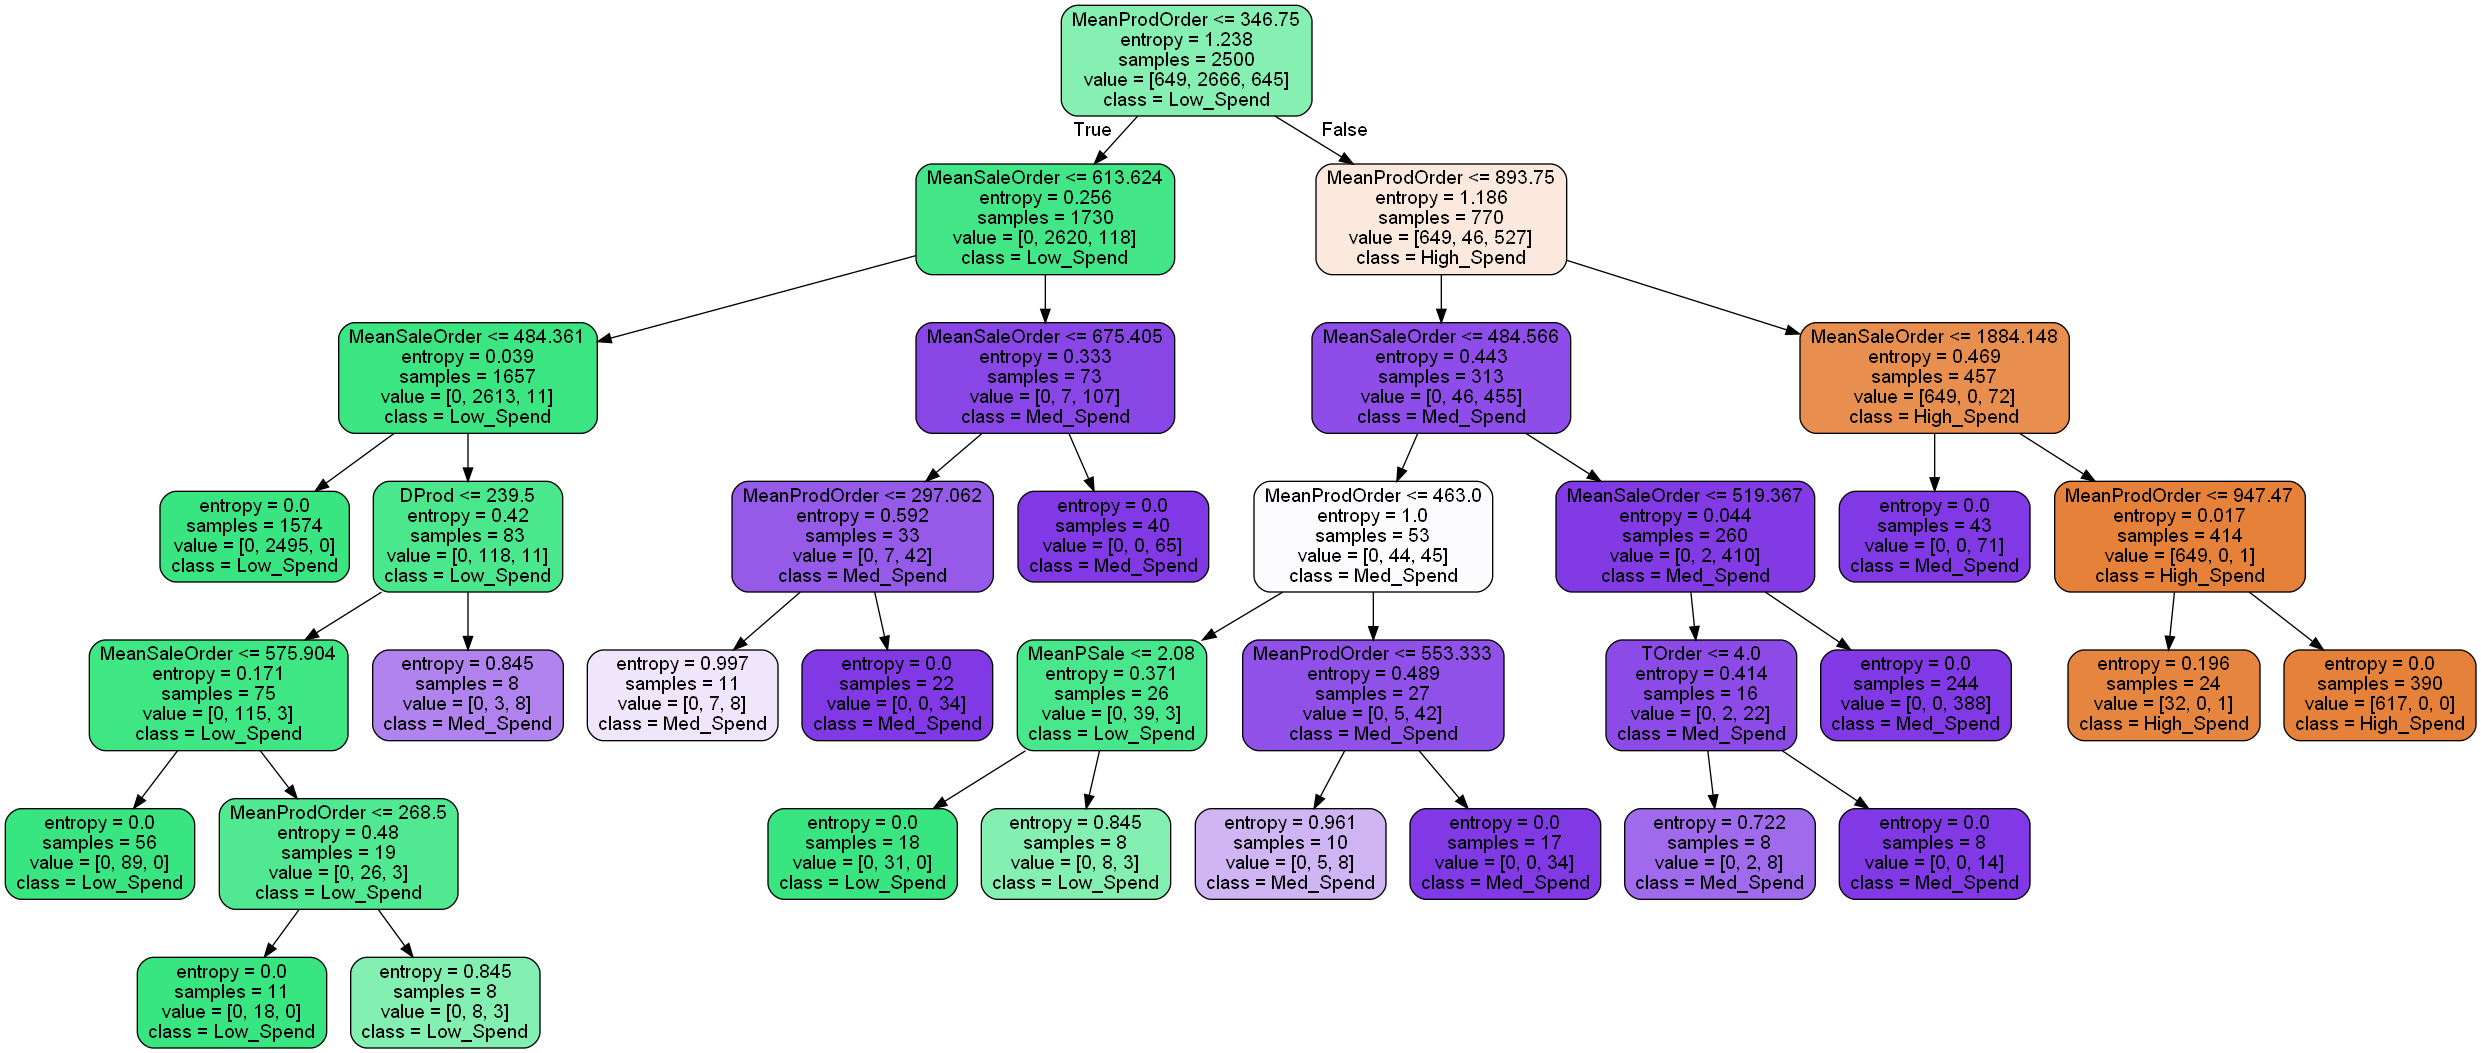

In [135]:
dot_data_over = tree.export_graphviz(rf_over[0], out_file=None, 
                         feature_names=list(train_set_over.columns),  
                         class_names=classes,
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data_over)  
Image(graph.create_png())

# Classification with SVM

In [33]:
#linear,poly,rbf,sigmoid,precomputed
from sklearn.svm import SVC
svm = SVC(kernel='sigmoid', C=0.5, gamma='scale', probability=True)
svm.fit(train_set, train_label)

SVC(C=0.5, kernel='sigmoid', probability=True)

In [34]:
#prediction on the test test
test_pred_proba_svm = svm.predict_proba(test_set)

In [35]:
test_pred_svm = svm.predict(test_set)

In [36]:
#compute the performance of the model
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=classes))

              precision    recall  f1-score   support

  High_Spend       0.00      0.00      0.00         8
   Low_Spend       0.91      0.98      0.94      1157
   Med_Spend       0.41      0.19      0.26       135

    accuracy                           0.89      1300
   macro avg       0.44      0.39      0.40      1300
weighted avg       0.85      0.89      0.87      1300



C:\Users\beppe\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\beppe\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


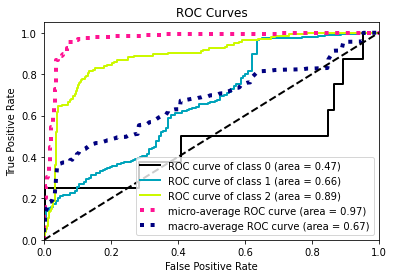

In [37]:
import scikitplot as skplt

skplt.metrics.plot_roc_curve(test_label.values, test_pred_proba_svm)
plt.show()